##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# 영화 리뷰를 사용한 텍스트 분류

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a>   </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td>GitHub에서 소스 보기</td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

이 튜토리얼은 디스크에 저장된 일반 텍스트 파일에서 시작하는 텍스트 분류를 보여줍니다. IMDB 데이터세트에 대한 감정 분석을 수행하도록 이진 분류기를 훈련합니다. 노트북의 마지막에는 스택 오버플로에서 프로그래밍 질문에 대한 태그를 예측하도록 다중 클래스 분류기를 훈련하는 연습을 시도해볼 수 있습니다.


In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [2]:
print(tf.__version__)

2.9.0


## 감정 분석

이 노트북은 리뷰 텍스트를 사용하여 영화 리뷰를 *긍정적* 또는 *부정적*으로 분류합니다. 중요하고 널리 적용 가능한 머신러닝 문제인 *이진* 분류의 예입니다.

[IMDB 데이터세트](https://ai.stanford.edu/~amaas/data/sentiment/)에는 [인터넷 영화 데이터베이스](https://www.imdb.com/)에서 가져온 50,000개의 영화 리뷰 텍스트가 포함되어 있습니다. 훈련용 리뷰 25,000개와 테스트용 리뷰 25,000개로 나뉩니다. 훈련 및 테스트 세트는 *균형을 이룹니다*. 즉, 동일한 수의 긍정적인 리뷰와 부정적인 리뷰가 포함되어 있습니다.


### 데이터세트 다운로드 및 탐색하기

데이터 세트를 다운로드하여 추출한 다음 디렉터리 구조를 살펴보겠습니다.

In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84125825/84125825 [==============================] - 21s 0us/step


In [4]:
os.listdir(dataset_dir)

['imdbEr.txt', 'test', 'imdb.vocab', 'README', 'train']

In [5]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'neg',
 'urls_pos.txt',
 'unsup',
 'urls_neg.txt',
 'pos',
 'unsupBow.feat',
 'labeledBow.feat']

`aclImdb/train/pos` 및 `aclImdb/train/neg` 디렉토리에는 각각 단일 영화를 리뷰한 많은 텍스트 파일이 포함되어 있습니다. 그 중 하나를 살펴보겠습니다.

In [6]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### 데이터세트 로드하기

다음으로, 디스크에서 데이터를 로드하고 훈련에 적합한 형식으로 준비합니다. 이를 위해 다음과 같은 디렉토리 구조를 예상하는 유용한 [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) 유틸리티를 사용합니다.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

이진 분류를 위한 데이터세트를 준비하려면 디스크에 `class_a` 및 `class_b`에 해당하는 두 개의 폴더가 필요합니다. 이것들은 `aclImdb/train/pos` 및 `aclImdb/train/neg`에서 찾을 수 있는 긍정적 영화 리뷰와 부정적 영화 리뷰입니다. IMDB 데이터세트에는 추가 폴더가 포함되어 있으므로 이 유틸리티를 사용하기 전에 제거합니다.

In [7]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

다음으로 `text_dataset_from_directory` 유틸리티를 사용하여 레이블이 지정된 `tf.data.Dataset`를 만듭니다. [tf.data](https://www.tensorflow.org/guide/data)는 데이터 작업을 위한 강력한 도구 모음입니다.

머신러닝 실험을 실행할 때 데이터세트를 [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set) 및 [test](https://developers.google.com/machine-learning/glossary#test-set)의 세 부분으로 나누는 것이 가장 좋습니다.

IMDB 데이터세트는 이미 훈련과 테스트로 나누어져 있지만 검증 세트가 부족합니다. 아래 `validation_split` 인수를 사용하여 훈련 데이터를 80:20으로 분할하여 검증 세트를 생성해 보겠습니다.

In [8]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Metal device set to: Apple M2


2023-03-02 13:17:52.734619: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-02 13:17:52.735269: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


위에서 볼 수 있듯이 training 폴더에는 25,000개의 예제가 있으며 그 중 80%(또는 20,000개)를 훈련에 사용할 것입니다. 잠시 후에 알 수 있겠지만 데이터세트를 `model.fit`에 직접 전달하여 모델을 훈련할 수 있습니다. `tf.data`를 처음 사용하는 경우 데이터세트를 반복하고 다음과 같이 몇 가지 예를 출력할 수도 있습니다.

In [9]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

2023-03-02 13:18:11.808030: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


리뷰에는 `<br/>`와 같은 간헐적 HTML 태그와 구두점을 포함한 원시 텍스트가 포함되어 있다는 점에 주목하세요. 다음 섹션에서 이를 처리하는 방법을 보여줍니다.

레이블은 0 또는 1입니다. 이들 중 어느 것이 긍정적이고 부정적인 영화 리뷰에 해당하는지 확인하려면 데이터세트에서 `class_names` 속성을 확인할 수 있습니다.


In [10]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


다음으로, 검증 및 테스트 데이터세트를 만듭니다. 검증을 위해 훈련 세트의 나머지 5,000개 리뷰를 사용합니다.

참고: `validation_split` 및 `subset` 인수를 사용할 때 검증 및 훈련 분할이 겹치지 않도록 임의 시드를 지정하거나 `shuffle=False`를 전달하는 것을 잊지 마세요.

In [11]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [12]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


### 훈련을 위한 데이터세트 준비하기

다음으로, 유용한 `tf.keras.layers.TextVectorization` 레이어를 사용하여 데이터를 표준화, 토큰화 및 벡터화합니다.

표준화는 일반적으로 구두점이나 HTML 요소를 제거하여 데이터세트를 단순화하기 위해 텍스트를 전처리하는 것을 말합니다. 토큰화는 문자열을 여러 토큰으로 분할하는 것을 말합니다(예: 화이트스페이스에서 분할하여 문장을 개별 단어로 분할). 벡터화는 토큰을 숫자로 변환하여 신경망에 공급될 수 있도록 하는 것을 말합니다. 이러한 모든 작업을 이 레이어에서 수행할 수 있습니다.

위에서 볼 수 있듯이 리뷰에는 `<br />`와 같은 다양한 HTML 태그가 포함되어 있습니다. 이러한 태그는 `TextVectorization` 레이어의 기본 표준화 도구로 제거되지 않습니다(텍스트를 소문자로 변환하고 기본적으로 구두점을 제거하지만 HTML은 제거하지 않음). HTML을 제거하기 위해 사용자 정의 표준화 함수를 작성합니다.

참고: [훈련-테스트 왜곡](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew)(훈련-제공 왜곡이라고도 함)를 방지하려면 훈련 및 테스트 시간에 데이터를 동일하게 전처리하는 것이 중요합니다. 이를 용이하게 하기 위해 `TextVectorization` 레이어를 모델 내에 직접 포함할 수 있습니다. 본 튜토리얼에서 나중에 이 내용을 알아봅니다.

In [13]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

다음으로 `TextVectorization` 레이어를 만듭니다. 이 레이어를 사용하여 데이터를 표준화, 토큰화 및 벡터화합니다. 각 토큰에 대해 고유한 정수 인덱스를 생성하도록 `output_mode`를 `int`로 설정합니다.

기본 분할 함수와 위에서 정의한 사용자 지정 표준화 함수를 사용하고 있습니다. 명시적 최대값인 `sequence_length`와 같이 모델에 대한 몇 가지 상수를 정의하여 레이어가 시퀀스를 정확히 `sequence_length` 값으로 채우거나 자르도록 합니다.

In [14]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

다음으로, 전처리 레이어의 상태를 데이터세트에 맞추기 위해 `adapt`를 호출합니다. 그러면 모델이 문자열 인덱스를 정수로 빌드합니다.

참고: adapt를 호출할 때 훈련 데이터만 사용하는 것이 중요합니다(테스트세트를 사용하면 정보가 누출됨).

In [15]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

2023-03-02 13:18:59.502565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


이 레이어를 사용하여 일부 데이터를 전처리한 결과를 확인하는 함수를 만들어 보겠습니다.

In [16]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [17]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

위에서 볼 수 있듯이 각 토큰은 정수로 대체되었습니다. 레이어에서 `.get_vocabulary()`를 호출하여 각 정수에 해당하는 토큰(문자열)을 조회할 수 있습니다.

In [18]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


모델을 훈련할 준비가 거의 되었습니다. 최종 전처리 단계로 이전에 생성한 TextVectorization 레이어를 훈련, 검증 및 테스트 데이터세트에 적용합니다.

In [19]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### 성능을 높이도록 데이터세트 구성하기

다음은 I/O가 차단되지 않도록 데이터를 로드할 때 사용해야 하는 두 가지 중요한 메서드입니다.

`.cache()`는 데이터가 디스크에서 로드된 후 메모리에 데이터를 보관합니다. 이렇게 하면 모델을 훈련하는 동안 데이터세트로 인해 병목 현상이 발생하지 않습니다. 데이터세트가 너무 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 뛰어난 온 디스크 캐시를 생성할 수도 있습니다. 많은 작은 파일보다 읽기가 더 효율적입니다.

`.prefetch()`는 훈련 중에 데이터 전처리 및 모델 실행과 겹칩니다.

[데이터 성능 가이드](https://www.tensorflow.org/guide/data_performance)에서 두 가지 메서드와 데이터를 디스크에 캐싱하는 방법에 관해 자세히 알아볼 수 있습니다.

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 모델 생성

이제 신경망을 만들 차례입니다.

In [21]:
embedding_dim = 16

In [22]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

층을 순서대로 쌓아 분류기(classifier)를 만듭니다:

1. 첫 번째 레이어는 `Embedding` 레이어입니다. 이 레이어는 정수로 인코딩된 리뷰를 입력 받고 각 단어 인덱스에 해당하는 임베딩 벡터를 찾습니다. 이러한 벡터는 모델이 훈련되면서 학습됩니다. 이들 벡터는 출력 배열에 차원을 추가합니다. 최종 차원은 `(batch, sequence, embedding)`이 됩니다. 임베딩에 대해 보다 자세히 알아보려면 [단어 임베딩](https://www.tensorflow.org/text/guide/word_embeddings) 튜토리얼을 확인하세요.
2. 그다음 `GlobalAveragePooling1D` 층은 `sequence` 차원에 대해 평균을 계산하여 각 샘플에 대해 고정된 길이의 출력 벡터를 반환합니다. 이는 길이가 다른 입력을 다루는 가장 간단한 방법입니다.
3. 이 고정 길이의 출력 벡터는 16개의 은닉 유닛을 가진 완전 연결(fully-connected) 층(`Dense`)을 거칩니다.
4. 마지막 층은 하나의 출력 노드(node)를 가진 완전 연결 층입니다. `sigmoid` 활성화 함수를 사용하여 0과 1 사이의 실수를 출력합니다. 이 값은 확률 또는 신뢰도를 나타냅니다.

### 손실 함수와 옵티마이저

모델이 훈련하려면 손실 함수(loss function)과 옵티마이저(optimizer)가 필요합니다. 이 예제는 이진 분류 문제이고 모델이 확률을 출력하므로(출력층의 유닛이 하나이고 `sigmoid` 활성화 함수를 사용합니다), `binary_crossentropy` 손실 함수를 사용하겠습니다.

이제 최적화 기와 손실 함수를 사용하도록 모델을 구성합니다.

In [23]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### 모델 훈련하기

`dataset` 개체를 fit 메서드에 전달하여 모델을 훈련합니다.

In [24]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


2023-03-02 13:19:42.817590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


624/625 [============================>.] - ETA: 0s - loss: 0.6636 - binary_accuracy: 0.6997

2023-03-02 13:19:54.660036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 13s 18ms/step - loss: 0.6635 - binary_accuracy: 0.6998 - val_loss: 0.6128 - val_binary_accuracy: 0.7754
Epoch 2/10
625/625 [==============================] - 6s 9ms/step - loss: 0.5421 - binary_accuracy: 0.8065 - val_loss: 0.4953 - val_binary_accuracy: 0.8246
Epoch 3/10
625/625 [==============================] - 6s 9ms/step - loss: 0.4343 - binary_accuracy: 0.8527 - val_loss: 0.4181 - val_binary_accuracy: 0.8482
Epoch 4/10
625/625 [==============================] - 5s 9ms/step - loss: 0.3646 - binary_accuracy: 0.8751 - val_loss: 0.3725 - val_binary_accuracy: 0.8606
Epoch 5/10
625/625 [==============================] - 5s 9ms/step - loss: 0.3179 - binary_accuracy: 0.8908 - val_loss: 0.3440 - val_binary_accuracy: 0.8656
Epoch 6/10
625/625 [==============================] - 5s 9ms/step - loss: 0.2831 - binary_accuracy: 0.9020 - val_loss: 0.3250 - val_binary_accuracy: 0.8714
Epoch 7/10
625/625 [==============================] - 5s 9ms/step - loss:

### 모델 평가하기

모델의 성능을 확인해 보죠. 두 개의 값이 반환됩니다. 손실(오차를 나타내는 숫자이므로 낮을수록 좋습니다)과 정확도입니다.

In [27]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 2ms/step - loss: 0.3107 - binary_accuracy: 0.8730
Loss:  0.31068193912506104
Accuracy:  0.8730400204658508


이 상당히 단순한 접근 방식은 약 86%의 정확도를 달성합니다.

### 정확도와 손실 그래프 그리기

`model.fit()`은 훈련 중에 발생한 모든 것을 가진 사전을 포함하는 `History` 객체를 반환합니다.

In [28]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

네 개의 항목이 있습니다. 훈련과 검증 단계에서 모니터링하는 지표들입니다. 훈련 손실과 검증 손실을 그래프로 그려 보고, 훈련 정확도와 검증 정확도도 그래프로 그려서 비교해 보겠습니다:

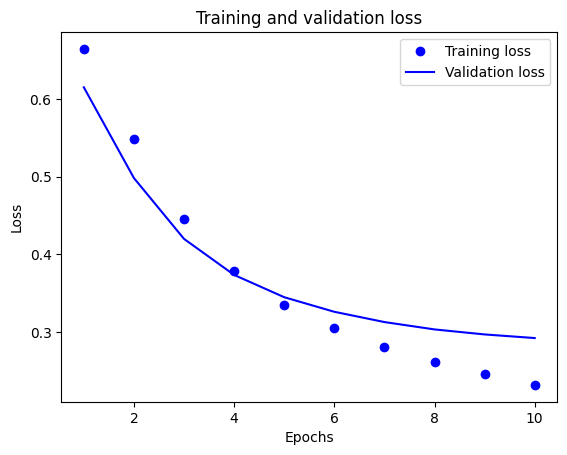

In [29]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

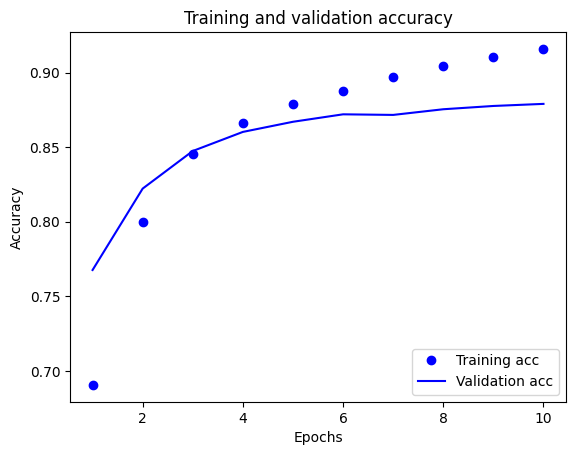

In [30]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

이 그래프에서 점선은 훈련 손실과 훈련 정확도를 나타냅니다. 실선은 검증 손실과 검증 정확도입니다.

훈련 손실은 각 epoch마다 *감소*하고 훈련 정확성은 각 epoch마다 *증가*합니다. 경사 하강 최적화를 사용할 때 이와 같이 예상됩니다. 모든 반복에서 원하는 수량을 최소화해야 합니다.

하지만 검증 손실과 검증 정확도에서는 그렇지 못합니다. 훈련 정확도 이전이 피크인 것 같습니다. 이는 과대적합 때문입니다. 이전에 본 적 없는 데이터보다 훈련 데이터에서 모델이 더 잘 동작합니다. 이 지점부터는 모델이 과도하게 최적화되어 테스트 데이터에서 *일반화*되지 않는 훈련 데이터의 *특정* 표현을 학습합니다.

여기에서는 과대적합을 막기 위해 단순히 검증 정확도가 더 이상 증가하지 않는 경우에 훈련을 중단할 수 있습니다. 이를 수행하는 한 가지 방법은 `tf.keras.callbacks.EarlyStopping` 콜백을 사용하는 것입니다.

## 모델 내보내기

위의 코드에서는 모델에 텍스트를 제공하기 전에 `TextVectorization` 레이어를 데이터세트에 적용했습니다. 모델이 원시 문자열을 처리할 수 있도록 하려면(예: 배포를 단순화하기 위해) 모델 내부에 `TextVectorization` 레이어를 포함할 수 있습니다. 이를 위해 방금 훈련한 가중치를 사용하여 새 모델을 만들 수 있습니다.

In [31]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 3s 4ms/step - loss: 0.3107 - accuracy: 0.8730
0.8730400204658508


### 새로운 데이터로 추론하기

새로운 예에 대한 예측을 얻으려면 간단히 `model.predict()`를 호출하면 됩니다.

In [32]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 137ms/step


array([[0.6096767],
       [0.4326959],
       [0.3506354]], dtype=float32)

모델 내부에 텍스트 전처리 논리를 포함하면 배포를 단순화하고 [훈련/테스트 왜곡](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) 가능성을 줄이는 프로덕션용 모델을 내보낼 수 있습니다.

TextVectorization 레이어를 적용할 위치를 선택할 때 염두에 두어야 할 성능 차이가 있습니다. 레이어를 모델 외부에서 사용하면 GPU에서 훈련할 때 비동기 CPU 처리 및 데이터 버퍼링을 수행할 수 있습니다. 따라서 GPU에서 모델을 훈련하는 경우 모델을 개발하는 동안 최상의 성능을 얻기 위해 이 옵션을 사용하고 배포 준비가 완료되면 모델 내부에 TextVectorization 레이어를 포함하도록 전환할 수 있습니다.

모델 저장에 대해 자세히 알아보려면 이 [튜토리얼](https://www.tensorflow.org/tutorials/keras/save_and_load)을 방문하세요.

## 연습: 스택 오버플로 질문에 대한 다중 클래스 분류

이 튜토리얼은 IMDB 데이터세트에서 이진 분류자를 처음부터 훈련하는 방법을 보여주었습니다. 연습으로, 이 노트북을 수정하여 [스택 오버플로](http://stackoverflow.com/)에서 프로그래밍 질문의 태그를 예측하도록 다중 클래스 분류자를 훈련할 수 있습니다.

스택 오버플로에 게시된 수천 개의 프로그래밍 질문(예: "Python에서 값을 기준으로 사전을 정렬할 수 있는 방법은?")의 본문이 포함된 [데이터세트](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz)가 준비되어 있습니다. 이들 각각은 정확히 하나의 태그(Python, CSharp, JavaScript 또는 Java)로 레이블이 지정됩니다. 여러분이 할 작업은 질문을 입력으로 받아 적절한 태그(이 경우 Python)를 예측하는 것입니다.

작업할 데이터세트에는 1,700만 개 이상의 게시물이 포함된 [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow)의 훨씬 더 큰 공개 스택 오버플로 데이터세트에서 추출한 수천 개의 질문이 포함되어 있습니다.

데이터세트를 다운로드해 보면 이전에 작업한 IMDB 데이터세트와 유사한 디렉터리 구조를 가지고 있음을 알 수 있습니다.

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

참고: 분류 문제의 난이도를 높이기 위해 프로그래밍 질문에서 Python, CSharp, JavaScript 또는 Java라는 단어의 출현은 *blank*라는 단어로 대체되었습니다(많은 질문에 해당 언어가 포함됨).

이 연습을 완료하려면 다음과 같이 수정하여 스택 오버플로 데이터세트와 함께 작동하도록 이 노트북을 수정해야 합니다.

1. 노트북 상단에서, 미리 준비된 [스택 오버플로 데이터세트](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz)를 다운로드하는 코드로 IMDB 데이터세트를 다운로드하는 코드를 업데이트합니다. 스택 오버플로 데이터세트는 유사한 디렉터리 구조를 가지므로 많이 수정할 필요가 없습니다.

2. 이제 4개의 출력 클래스가 있으므로 `Dense(4)`를 읽도록 모델의 마지막 레이어를 수정합니다.

3. 모델을 컴파일할 때 손실을 `tf.keras.losses.SparseCategoricalCrossentropy`로 변경합니다. 이것은 각 클래스의 레이블이 정수일 때(이 경우 0, *1*, *2* 또는 *3*일 수 있음) 다중 클래스 분류 문제에 사용할 올바른 손실 함수입니다. 또한 이것은 다중 클래스 분류 문제이기 때문에 메트릭을 `metrics=['accuracy']`로 변경합니다(`tf.metrics.BinaryAccuracy`는 이진 분류자에만 사용됨).

4. 시간 경과에 따른 정확도를 표시할 때 `binary_accuracy` 및 `val_binary_accuracy`를 각각 `accuracy` 및 `val_accuracy`로 변경합니다.

5. 이러한 변경이 완료되면 다중 클래스 분류자를 훈련할 수 있습니다. 

## 더 알아보기

이 튜토리얼은 텍스트 분류를 처음부터 알아보았습니다. 일반적인 텍스트 분류 워크플로에 대해 자세히 알아보려면 Google Developers의 [텍스트 분류 가이드](https://developers.google.com/machine-learning/guides/text-classification/)를 확인하세요.
